# Задачи классификации

Задача классифификации (classification) - метод обучения с учителем (supervised)

Классификация - задача для алгоритмов машинного обучения восстановить на объектах обучающей выборки **метки классов**. Классы - конечный (дискретный) набор целевых переменных. Например, в задаче фильтрации спама два класса: спам (метка $1$) и не спам (метка $0$)

Классификация бывает бинарная (когда классов всего два: $0$ и $1$) и мультиклассовая, когда классов несколько. Если научились классифицировать на два класса, то и на несколько получиться: метод One vs All.

Подключаемся к гугл драйв

In [1]:
import logging
import os
import shutil 

import numpy as np
# from google.colab import drive

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  # гарантируем воспроизводимость

logging.getLogger().setLevel(logging.INFO)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info('Инициализировали логгер')

ROOT_DIR = '/content/drive' 
drive.mount(ROOT_DIR)
logger.info('Подключили диск')

root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', 'ml-compling-2022-hse', 'data')
if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')
else:
  logger.info('Содержимое директории %s: %s', root_data_dir, os.listdir(root_data_dir))

ModuleNotFoundError: No module named 'google.colab'

Загружаем данные - у нас будет новый датасет с задачей классификации

In [2]:
import os

import numpy as np
import pandas as pd

raw_data_file = '/Users/alexandradolidze/Downloads/client_segmentation.csv'

# задаём типизацию колонок чтобы память экономить
df_source = pd.read_csv(
    raw_data_file, sep=',',
    dtype={
        'call_diff': np.float32,
        'call_diff': np.float32,
        'traffic_diff': np.float32,
        'customes_class': np.uint16
    }
)

df_source.head(5)

,call_diff,sms_diff,traffic_diff,customes_class
0,-0.666421,0.444911,-0.273538,0
1,-0.889273,-0.537896,-1.959469,2
2,-0.841503,0.846665,0.727606,0
3,1.389749,0.390911,1.789246,1
4,-1.228211,-1.375899,-1.434209,2


В файле `client_segmentation.csv` содержатся данные по оттоку: информация по клиентам оператора связи о том, как изменилось потребление услуг оператора за два месяца:
* call_diff доля звонков
* sms_diff доля смс
* доля интернет-трафика traffic_diff

Значение отрицательное - показатель снизился. Значение превосходит по модулю единицу - потребление кратно выросло. 

Все показатели вычисляются по формуле

$$
\frac{\text{new_value}-\text{old_value}}{\text{old_value}}
$$

Посмотрим на распределение какой-нибудь фичи, например `sms_diff`

<AxesSubplot: >

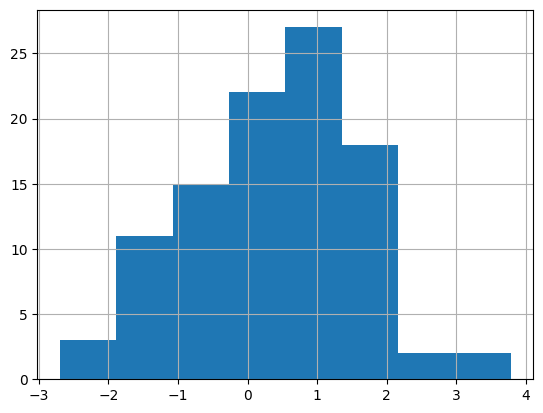

In [3]:
df_source.sms_diff.hist(bins=8)

В последней колонке `customes_class` содержится метка по оттоку:
* $0$ - активный пользователь
* $1$ - "спящий" пользователь (редко пользуется услугами)
* $2$ - пользователь, который ушел в отток

Это наша целевая переменная, хотим её предсказывать

In [9]:
print('num train samples', df_source.shape[0])
df_source.customes_class.value_counts(normalize=True)

num train samples 100


0    0.34
2    0.33
1    0.33
Name: customes_class, dtype: float64

Видим, что у нас примерно одинакоково представлены все классы. Ситуация, когда один класс представлен слишком сильно и ли наоборот слишком слабо в выборке называется "дисбаланс классов". 

Есть два основных приёма решения проблемы дисбаланса
* undersampling доминирующего класса
* oversampling класса с меньшим числом элементов

Важный момент: дальше мы будем решать задачу классификации на 2 класса

Для этого искусственно разделим класс `2` между классами `0` и `1`

In [10]:
df_source[(df_source.customes_class==2) & (df_source.call_diff>1.1)] = 0
df_source[(df_source.customes_class==2) & (df_source.call_diff<=1.1)] = 1

X = df_source[['call_diff','sms_diff','traffic_diff']].values
y = df_source.customes_class.values

# Naive Bayes

Попробуем для решения задачи использовать классификатор "из коробки": воспользуемся  [наивным Байесовским классификатором](https://scikit-learn.org/stable/modules/naive_bayes.html). Кстати, реализация содержит функцию `.partial_fit()` с которой мы уже встречались! Вспомните где именно.

Этот классификатор основан на частотах встречаемости фичей. У нас фичи непрерывные, так что вместо частот будем использовать вероятности.

Классификатор очень быстро обучается, т.к. по сути нам нужно просто посчитать разные статистики по выборке - никакого градиентного спуска тут нет.

Пусть $c$ - класс объекта (у нас три класса) тогда мы берём объект и предсказываем вероятности по формуле Байеса для всех трёх классов, а класс объекту присваиваем тот, у которого максимальная вероятность - это называется Maximum a posteriori (MAP) estimation, метод максимальной апостериорной вероятност (потому что формула Байеса для вычисляет апостериорную вероятност гипотезы) 

$$
c_{MAP} = \arg \max_{\substack{c \in C}}P(c \mid X) = \arg \max_{\substack{c \in C}}\frac{P(c)P(X\mid c)}{P(X)}
$$

В формуле
* P(c) - вероятность класса, его встречаемость
* P(X|c) - вероятность встретить объект с конкретными фичами в конкретном классе, то есть насколько объект объект ожидаем встретить в классе $c$
* P(X) - распределение данных. Т.к. мы ищем максимум по всем $c$, а знаменатель от C не зависит, то его вообще можно не учитывать

Для начала вычислим априорные вероятности классов $P(c)$

In [11]:
from collections import Counter

num_samples = df_source.shape[0]  # число объектов
prior_class_counts = Counter(y)  # группируем по классу и считаем колияество объектов каждого класса
prior_class_probs = dict() # тут будем хранить  априорные вероятности классов
print(prior_class_counts)

for class_label in prior_class_counts:
  prior_class_probs[class_label] = prior_class_counts[class_label] / num_samples
print(prior_class_probs)

Counter({1: 66, 0: 34})
{0: 0.34, 1: 0.66}


Как посчитать $P(X\mid c)$? Каждый объект $x \in X$ состоит из фичей, это вектор $x = [x_1, \ldots, n_n ]$, в нашем случае это из три элементов (у нас три фичи). Классификатор называется *наивным*, потому что мы делаем предположение о независимости фичей - в этом случае совместное распределение можно расписать через произведение маргинальных распределений

$$
P(X\mid c) = P(x_1\ldots x_n\mid c) = P(x_1 \mid c)\cdot \ldots \cdot P(x_n\mid c) = \prod_{i=1}^nP(x_i\mid c)
$$

Небольшое преобразование: т.к. ищем максимум то можем применить логарифм чтобы перейти от произведения к сумме (т.к. логарифм фозрастающая функция и на точку максимума не вилияет

$$
\ln P(X\mid c) = \ln\prod_{i=1}^nP(x_i\mid c) = \sum_{i=1}^n\log P(x_i\mid c)
$$

Как для конкретной фичи $x_i$ найти $P(x_i\mid c)$? Для непрерывной фичи придётся ввести предположение о том, что фича имеет гауссовское распределение, то есть 

$$
P(x_i\mid c) = \frac{1}{\sqrt{2\pi \sigma^2_{x|c}}}\exp\left(-\frac{(x - \mu_{x|c})^2}{2\sigma^2_{x|c}}\right)
$$

Где $\sigma_{x|c}$ - СКО фичи $x$ для класса $c$, $\mu_{x|c}$ - МО фичи $x$ для класса $c$. Это параметры гауссовского распределения - их мы оценим по выборке.

Алгоритм оценки параметров следующий:
* берём класс $c$
* оставляем в датасете только примеры этого класса $c$
* вычисляем $\sigma_{x|c}$ и $\mu_{x|c}$

В результате получим словарь, где ключ - имя фичи, а значение - вложенный словарь, где ключ - метка класса, а значение - параметры гауссовского распределения фичи этом классе, то есть получаем структуру вида 
```python
{
  class_1: {mu: some_value, sigma: some_value},
  class_2: {mu: some_value, sigma: some_value},
  class_3: {mu: some_value, sigma: some_value}
}
```

Работать будем с `pandas.DataFrame` чтобы упростить фильтрацию и подсчёт статистик

In [12]:
from collections import defaultdict

target_col = 'customes_class'
feature_names = ['call_diff','sms_diff','traffic_diff']

feature_proba_param = defaultdict(dict)
for col in feature_names:  # цикл по фичам
  for class_id in prior_class_probs:  # цикл по классам
    feature_values = df_source[df_source[target_col]==class_id][col]  # отфильтруем фичу по классу
    feature_proba_param[col][class_id] = {
        'mu': feature_values.mean(), 
        'sigma': feature_values.std()
    }
# посмотрим распределение статистике по конкретной фиче
feature_example = 'call_diff'
print(feature_example)
feature_proba_param[feature_example]

call_diff


{0: {'mu': -1.0015249, 'sigma': 0.74156827},
 1: {'mu': 1.1297727, 'sigma': 0.44200704}}

По сути мы нашли  параметры распределения - можем посчитать вероятности классов

Теперь можем построить алгоритм предсказания с помощью MAP
* для объекта $x$ считаем $P(c_1 | X), P(c_2 | X), P(c_3 | X)$
* выбираем максимальную вероятность - это и будет наше предсказание

время познакомится с библиотекой [scipy](https://docs.scipy.org/) - оттуда возьмём реализацию $P(X | c)$ для [распределения гаусса](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)

In [20]:
from scipy.stats import norm


def eval_bayes(row):
  log_classes_probas = defaultdict(float)  # т.к. нужно собирать сумму из разных фичей
  for feature in feature_names:
    feature_params = feature_proba_param[feature]  # извлекаем параметры распределения фичи (там три класса)
    for class_id in feature_params:  # считаем априорную вероятность получить такое значение фичи в каждом классе
      feature_class_params = feature_params[class_id]  # достаём параметры распределения (mu, sigma), которые посчитали на предыдущем шаге
      feature_class_proba = norm.pdf(
          row[feature],
          loc=feature_class_params['mu'], scale=feature_class_params['sigma']
      )
      # вероятность в интервале [0, 1] - там отрицательные значения логарифма
      log_classes_probas[class_id] += np.log(feature_class_proba)
  sorted_log_classes_probas = sorted(log_classes_probas.items(), key = lambda x: x[1], reverse=True)
  predicted_class, predicted_class_proba = sorted_log_classes_probas[0]
  return predicted_class, predicted_class_proba

def predict(input_df):
  res = []
  for _, row in input_df.iterrows():
    class_label, _ = eval_bayes(row)
    res.append(class_label)
  return res

def predict_proba(input_df):
  res = []
  for _, row in input_df.iterrows():
    _, class_proba = eval_bayes(row)
    res.append(class_proba)
  return res

# predict_proba(df_source[feature_names].head(1))
predicted_classes = predict(df_source[feature_names])
accuracy = (predicted_classes == y).sum() / len(y)

print(f'Предсказания построены, accuracy = {accuracy:.2f}')

Предсказания построены, accuracy = 0.96


Проверим точность классификатора в реализации sklearn

In [21]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB() # создаём экземпляр класса
naive_bayes.fit(X, y) # обучение модели
predicted_classes = naive_bayes.predict(X) # предсказание (эксплуатация модели)

accuracy = (predicted_classes == y).sum() / len(y)

print(f'Предсказания построены, accuracy = {accuracy:.2f}')

Предсказания построены, accuracy = 0.97


Визуализируем confusion matrix

Кoличество объектов в тестовой выборке: 33


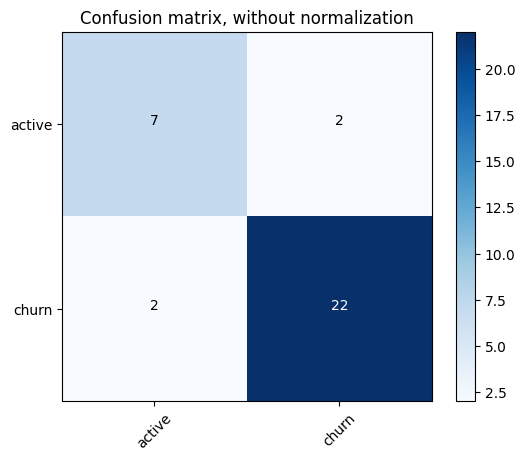

In [22]:
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools

# сводим задачу к бинарной классификации
# df_source = pd.read_csv(
#     'data/client_segmentation.csv', 
#     dtype={'call_diff': np.float32, 'call_diff': np.float32, 'traffic_diff': np.float32, 'customes_class': np.uint16}
# )

X = df_source[['call_diff','sms_diff','traffic_diff']].values
y = df_source.customes_class.values

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
naive_bayes.fit(X_train, y_train)
y_pred = naive_bayes.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(
    conf_matrix,
    classes=['active', 'churn'],
    title='Confusion matrix, without normalization'
)
print(f'Кoличество объектов в тестовой выборке: {len(y_pred)}')

Самостоятельное задание: постройте бейзлайн в виде рандомного предсказания классов. Выбор класса должен делаться случайным образом, но вероятность класса $1$ возьмите такую же, как в исходном датасете. 

In [51]:
# --------- ВАШ КОД ТУТ --------
import random

RANDOM_SEED = 100
random.seed(RANDOM_SEED)

classes = df_source.customes_class.unique()
weights = df_source.customes_class.value_counts(normalize=True)
size = len(df_source[feature_names])

y_pred_random = random.choices(classes, weights = weights, k = size)

accuracy = (y_pred_random == y).sum() / len(y)

print(f'Предсказания построены, accuracy = {accuracy:.2f}')
# --------------------------------

Предсказания построены, accuracy = 0.42


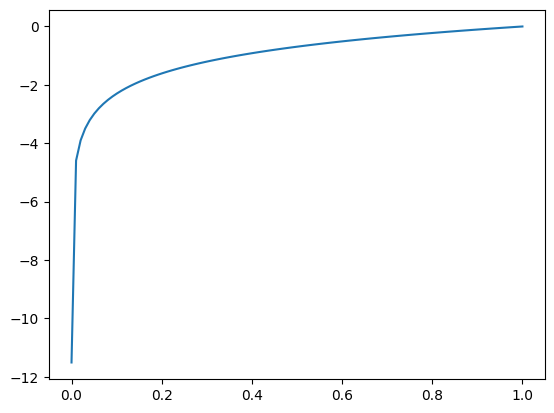

In [52]:
import numpy as np
from matplotlib import pyplot as plt
x_space = np.linspace(0.00001, 1, num=100)
plt.plot(x_space, np.log(x_space))

# Logistic regression

Другой интересный классификатор, для обучения которого уже применим градиентнй спуск - это логистическая регрессия

Для понимания логистической регресси представим что у нас есть задача бинарной классификации, где два класса: класс $1$ (успех) и класс $0$ (неуспех), вероятность успеха обозначим $p$

Шансы на успех (odds) - это отношение числа успехов  к числу неуспехов

$$
odds = \frac{p}{1-p}
$$

В отличие от вероятности эта величина может быть как меньше единицы (если вероятность успеха меньше $0.5$) так и больше единицы (если вероятность успеха больше $0.5$). Термин шировко применяется в ставкав: допустим, мы выиграли в 15 играх из 100: в этом случае шансы на успех всего $\frac{15}{85}=\frac{3}{17}=0.17$ c другой стороны, если выиграть 60 игр из 100 то шансы на успех уже $\frac{60}{40}=\frac{3}{2}=1.5$



Теперь проведем небольшьшой трюк и логарифмируем наши шансы на успех

$$
\log odds = \log \frac{p}{1-p}
$$

График логарифма мы строили ранее в этом семинаре: для значений от $0$ до $1$ получим отрицательные значения, выше - положительные

Мы знаем, что линейная регрессия $\hat{y} = w_0x_0 + \ldots w_nx_n$ "умеет" предсказывать величины от $-\infty$ до $\infty$. Получается, мы по данным $X$ хотим предсказывать шансы на успех (как в ставках на спорт), например для конкретного объекта x у которого $n$ фичей:

$$
w_0x_0 + \ldots w_nx_n = \overline{w}x = \log \frac{p}{1-p}
$$

Превращаем логарифм в экспоненту
$$
\exp(\overline{w}x) = \frac{p}{1-p}
$$

И окончательно выражаем вероятность успеха $p$ для конкретного объекта $x_i$:
$$
p_i = \frac{1}{1+e^{-\overline{w}x_i}}
$$

Функция $\sigma (z) = \frac{1}{1+e^{-z}}$ называеся *сигмоидой* - в курсе по нейросетям с сигмоидой вы встретитесь ещё не раз. Она обладает рядом интересных свойств, например $\sigma (-z) = 1 - \sigma (z)$

Дальше нужно подобрать оптимальные веса $w$. В задаче линейной регресси эмирический риск $Q_{\text{emp}}$ мы считали как сумму квадратов отклонений предикта от таргета. Тут мы аналогично алгоритму наивного байеса воспользуемся достижениями из тервера и выпишем *правдоподобие данных* для выборки из распределения Бернулли (т.к. $y_i=0$ либо $y_i=1$ ) размера $N$:
$$
P(y | X, w) = \prod_{i}^N p^{y_i}(1-p)^{1-y_i}
$$
Чтобы избавиться от произведения переходим к логарифмам (т.к. нам нужно найти точку максимума и логарифмирование на эту точку всё равно не повлияет)
$$
\log P(y | X, w) = \sum_{i}^{N} y_i \log p_i + (1-y_i)\log(1-p_i)
$$

Т.к. $p=\sigma (z)$ и $\sigma (-z) = 1 - \sigma (z)$ то окончательно получаем
$$
\log P(y | X, w) = \sum_{i}^{N} y_i \log \sigma (z) + (1-y_i)\log(\sigma (-z))
$$

Правдоподобие нужно *максимизировать*, тогда функционал эмпирического риска, который мы минимизируем:
$$
L(y, X, w) = - \sum_{i}^{N} y_i \log \sigma (z) + (1-y_i)\log(\sigma (-z))
$$

Кстати, такая функция потерь называется "бинарная кросс-энтропия" или *BCE (binary crossemtropy loss)*. Аналитическое решение тут уже нельзя найти, зато отлично будет работать градиентный спуск, нужно только найти градиент функции потерь $L(Y, X, w)$

$$
\nabla L = \frac{1}{N}\left(Y - \hat{Y}\right)\cdot X
$$

Здесь $X$ - матрица объекты-признаки, а $\hat{Y} = \sigma(\overline{w}x)$.одробнее про вывод этой формулы можно почитать в разделе про [логиcтическую регрессию](https://ml-handbook.ru/chapters/linear_models/intro) - только там не совсем правильно, т.к. нет усреднения ошибки.

Можем реализовать на python (вот [тут](https://towardsdatascience.com/logistic-regression-from-scratch-in-python-ec66603592e2) подробнее и с картинками). Для начала сигмоиду

In [53]:
def sigmoid(z):
  return 1 / ( 1. + np.exp(-z))

x = np.array([1, 2, 3, 5])
sigmoid(x)

array([0.73105858, 0.88079708, 0.95257413, 0.99330715])

Далее собственно градиентный спуск

In [54]:
from scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def gradient(X, y, w, alpha=0) -> np.array:
    """Вычисляем градиент в точке"""
    # количество обучающих примеров в выборке
    n = X.shape[0]
    # считаем прогноз
    y_hat = sigmoid(X.dot(w.T))
    # вычисляем ошибку прогноза
    error = (y - y_hat).reshape(1, -1)
    # дальше pointwise перемножение - умножаем каждую из координат на ошибку
    grad = (-1.) * error.dot(X) / n
    return grad, error

def eval_w_next(X, y, eta, w_current):
    """Делаем шаг градиентного спуска"""
    # вычисляем градиент
    grad, error = gradient(X, y, w_current)
    # делаем шаг градиентного спуска
    w_next = w_current - eta*grad
    # проверяем условие сходимости
    weight_evolution = distance.euclidean(w_current, w_next)
    return (w_next, weight_evolution, grad)

Повторяем шаги до сходимости

In [55]:
def gradient_descent(X: np.array, y: np.array, eta=0.01, epsilon=0.001) -> np.array:
    m = X.shape[1] # количество фичей
    # инициализируем рандомом веса
    w = np.random.random(m).reshape(1, -1)
    w_next, weight_evolution, grad = eval_w_next(X, y, eta, w)
    step = 0
    # повторяем до сходимости вектора весов
    while weight_evolution > epsilon:
        w = w_next
        w_next, weight_evolution, grad = eval_w_next(X, y, eta, w)
        step += 1
        if step % 100 == 0:
            print("step %s |w-w_next|=%.5f, grad=%s" % (step, weight_evolution, grad))
    return w

# добавляем тривиальный признак w_0, столбец из единиц. См. прошлый урок, почему так
X_extended = np.hstack([
    np.ones(X.shape[0]).reshape(-1,1),
    X
])
w = gradient_descent(
    X_extended,
    y.reshape(-1, 1),
    eta=0.008
)

step 100 |w-w_next|=0.00335, grad=[[ 0.14471559 -0.29080525  0.13451325  0.22725221]]
step 200 |w-w_next|=0.00261, grad=[[ 0.09692591 -0.24838453  0.07914115  0.1710438 ]]
step 300 |w-w_next|=0.00206, grad=[[ 0.06242417 -0.21254249  0.03865657  0.12547547]]
step 400 |w-w_next|=0.00169, grad=[[ 0.04064907 -0.18472803  0.0130487   0.09426067]]
step 500 |w-w_next|=0.00145, grad=[[ 0.02759291 -0.16307762 -0.00227086  0.07409879]]
step 600 |w-w_next|=0.00128, grad=[[ 0.01983082 -0.14582509 -0.01132707  0.06103861]]
step 700 |w-w_next|=0.00115, grad=[[ 0.01517733 -0.1317668  -0.01669817  0.05231134]]
step 800 |w-w_next|=0.00105, grad=[[ 0.01235231 -0.12010273 -0.01989456  0.0462283 ]]


In [56]:
X_extended.shape

(100, 4)

In [91]:
def predict(X, w):
  y_probas = sigmoid(X.dot(w.T))
  y_hat = np.zeros_like(y_probas)
  y_hat[np.where(y_probas >= 0.5)] = 1
  y_hat[np.where(y_probas < 0.5)] = 0
  y_hat = y_hat.flatten().astype(np.uint16)

  return y_hat

predicted_classes = predict(X_extended, w)
accuracy = (predicted_classes == y).sum() / len(y)
print(f'Предсказания построены, accuracy = {accuracy:.2f}')

Предсказания построены, accuracy = 0.9500


Сраваним с "коробочной" реализацией

In [90]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression().fit(X, y)

predicted_classes_sklearn = log_reg.predict(X)
accuracy = (predicted_classes == y).sum() / len(y)
print(f'Предсказания построены, accuracy = {accuracy:.2f}')

Предсказания построены, accuracy = 0.9500


Самостоятельное задание: посчитать используя библиотеку sklearn и визуализировать ROC-AUC для двух логистических регрессий выше.

Наш ROC-AUC score = 0.9955436720142602


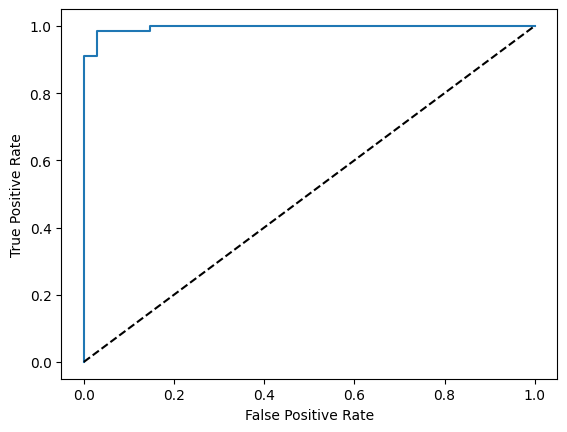

Коробочный ROC-AUC score = 1.0


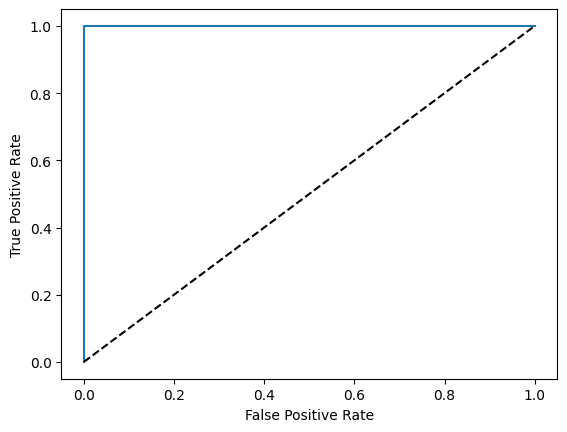

In [88]:
# --------- ВАШ КОД ТУТ --------
from sklearn.metrics import roc_curve, roc_auc_score

def count_and_draw_roc_curve(y_true, y_score, explanation):
    
    auc_score = roc_auc_score(y_true, y_score)
    print(f'{explanation} ROC-AUC score = {auc_score}')
    
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], linestyle='dashed', color='black')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return


y_probas = sigmoid(X_extended.dot(w.T))
y_probas_sklearn = log_reg.predict_proba(X)[:,1]
# print(y_probas)
# print(y_probas_sklearn[:,1])

count_and_draw_roc_curve(y, y_probas, 'Наш')
count_and_draw_roc_curve(y, y_probas_sklearn, 'Коробочный')
# --------------------------------

Итог: Обе модели идеально (наша - почти идеально) различают классы

Бонус уровень (+2 балла к этому заданию, если есть понижение): самостоятельно реализовать функцию roc_auc_score и сравнить ее с результатами выше.

In [97]:
# --------- ВАШ КОД ТУТ --------

# примерный план:
# построить точки ROC по thershold -- ROC кусочно-заданная от точки до точки 
# точки соответствуют соотношению Sensitivity и Specificity
# надо посчитать TPR и FPR
# посчитать площадь под ROC

# https://www.youtube.com/watch?v=4jRBRDbJemM

def count_roc_auc_score(y_true, y_score, explanation):
    
    _, _, thresholds = roc_curve(y_true, y_score)
    
    

count_roc_auc_score(y, y_probas, 'Наш')
count_roc_auc_score(y, y_probas_sklearn, 'Коробочный')
# --------------------------------